In [1]:
from pathlib import Path

from src.dino.opencv import *
from src.tone_mappers.bronto import *

def bronto_L_bar(
    rgb_image: np.ndarray,
    cs_ratio: float = 2.0,
    num_scales: int = 13,
    w: float = 0.9,
    m: float = 0.1,
    d_nit_arcmin2: float = 100,
    image_fov_degrees: float = 72,
) -> np.ndarray:
    X, Y, Z = rgb_to_xyz(rgb_image)
    L, _, _ = xyz_to_lxy(X, Y, Z)

    d = arcmin2_to_pixel2(d_nit_arcmin2, L.shape[1], image_fov_degrees)
    # Compute ratios and weighted sum using only two blurred images at a time
    center_response = None
    accum = np.zeros_like(L)
    c_sum = np.zeros_like(L)
    i = 0
    for scale, surround_response in gaussian_blur_all_scales(L, cs_ratio, num_scales):
        if center_response is not None:
            _d = d / scale**2
            c = w * np.abs((center_response + _d) / (surround_response + _d) - 1) + m
            accum += c * surround_response
            c_sum += c
            i += 1
        center_response = surround_response

    return accum / c_sum


def brontosaurus_L_bar(
    rgb_image: np.ndarray,
    white_base: float = 1.2,
    *args,
    **kwargs,
) -> np.ndarray:
    X, Y, Z = rgb_to_xyz(rgb_image)
    L, _, _ = xyz_to_lxy(X, Y, Z)
    brightness_map = dinos_efficient(L, *args, **kwargs)
    return white_base ** brightness_map


INPUT_IMAGE = Path("images/DelicateArch.exr")
image = read_image(str(INPUT_IMAGE))
OUTPUT_PATH = Path("_output")
blurred = bronto_L_bar(image)
sharp = brontosaurus_L_bar(image)

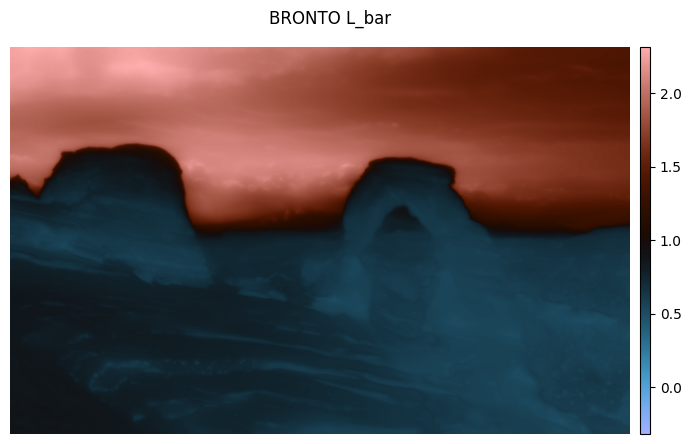

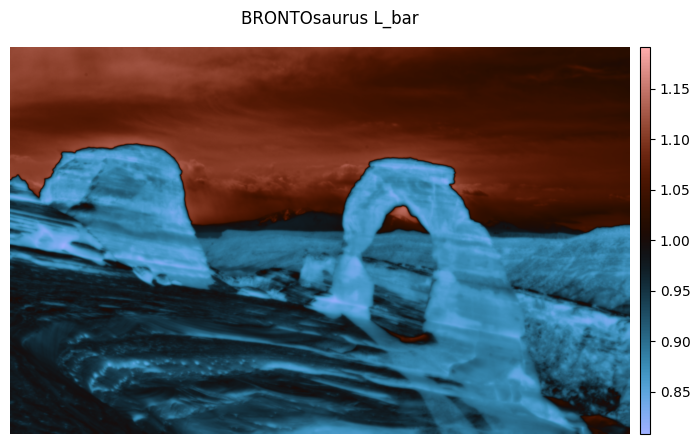

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import CenteredNorm

for title, lbar in [("BRONTO L_bar", blurred), ("BRONTOsaurus L_bar", sharp)]:
    fig = plt.figure()
    fig.suptitle(title)
    grid = ImageGrid(
        fig,
        (0, 0, 1, 1),
        nrows_ncols=(1, 1),
        axes_pad=(0.35, 0.05),
        cbar_location="right",
        cbar_mode="each",
        cbar_size=0.1,
        cbar_pad=0.1,
    )
    ax = grid[0]
    cax = grid.cbar_axes[0]
    im = ax.imshow(lbar, cmap="berlin", aspect="equal", norm=CenteredNorm(vcenter=1))
    cbar = cax.colorbar(im)
    ax.axis("off")